# Predicting Single-Day Ski Resort Lift Ticket Prices

## Web Scraping and Data Processing

In [1]:
# Import libraries.
import time
import numpy as np
import pandas as pd

import requests
from bs4 import BeautifulSoup as bs

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold

import seaborn as sns
import matplotlib.pyplot as plt

### [www.skiresort.info](https://www.skiresort.info/ski-resorts/usa) web scraping

In [2]:
df = pd.DataFrame(columns=['Resort',
                           'Location',
                           'Base Elevation (m)',
                           'Peak Elevation (m)',
                           'Vertical Drop (m)',
                           'Ski Lifts',
                           'Green Trails (km)',
                           'Blue Trails (km)',
                           'Black Trails (km)',
                           'Total Trails (km)',
                           'Lift Ticket Price (USD)'])

for page in range(4):
    source = requests.get('https://www.skiresort.info/ski-resorts/usa/page/%d/' % page).text
    soup = bs(source, 'lxml')
    resorts = soup.find('div', id='resortList')
    resorts = resorts.find_all('div', class_='panel panel-default resort-list-item resort-list-item-image--big')
    for resort in resorts:
        try:
            df = df.append({'Resort': resort.find('a', class_='h3').contents[0].strip().replace(' â ', ', '),
                            'Location': resort.find('div', class_='sub-breadcrumb').find_all('a')[-1].contents[0],
                            'Base Elevation (m)': resort.find_all('span')[2].contents[0].replace(' m', '').replace(' km', '000'),
                            'Peak Elevation (m)': resort.find_all('span')[3].contents[0].replace(' m', '').replace(' km', '000'),
                            'Vertical Drop (m)': resort.find_all('span')[1].contents[0].replace(' m', '').replace(' km', '000'),
                            'Ski Lifts': resort.find('li').contents[0].replace(' ski lift', '').replace('s', ''),
                            'Green Trails (km)': resort.find('span', class_='slopeinfoitem blue').contents[0].replace(' km', ''),
                            'Blue Trails (km)': resort.find('span', class_='slopeinfoitem red').contents[0].replace(' km', ''),
                            'Black Trails (km)': resort.find('span', class_='slopeinfoitem black').contents[0].replace(' km', ''),
                            'Total Trails (km)': resort.find('span', class_='slopeinfoitem ').contents[0].replace(' km', ''),
                            'Lift Ticket Price (USD)': resort.find_all('td')[-1].contents[0].split('/')[0].replace('US$ ', '').replace(',-', '').strip()},
                      ignore_index=True)
        except:
            pass

print(df.shape)
df.head()

(468, 11)


,Resort,Location,Base Elevation (m),Peak Elevation (m),Vertical Drop (m),Ski Lifts,Green Trails (km),Blue Trails (km),Black Trails (km),Total Trails (km),Lift Ticket Price (USD)
0,Vail,Colorado,2457,3433,976,25,57,84,93,234,228
1,Telluride,Colorado,2659,3815,1156,16,6.7,51.7,29.8,88.2,139
2,Beaver Creek,Colorado,2255,3488,1233,16,28.5,64.5,57,150,228
3,Mammoth Mountain,Mammoth Lakes,2424,3369,945,28,18.4,48.5,22.9,89.8,159
4,Snowmass,Aspen Snowmass,2473,3813,1340,17,14.2,111.4,111.4,237,179


#### Remove duplicates and convert the numeric fields to numeric values.

In [3]:
df = df.drop_duplicates()
numeric_columns = ['Base Elevation (m)', 'Peak Elevation (m)', 'Vertical Drop (m)',
                   'Ski Lifts',
                   'Green Trails (km)', 'Blue Trails (km)', 'Black Trails (km)', 'Total Trails (km)',
                   'Lift Ticket Price (USD)']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='raise')
print(df.shape)
df.head()

(418, 11)


,Resort,Location,Base Elevation (m),Peak Elevation (m),Vertical Drop (m),Ski Lifts,Green Trails (km),Blue Trails (km),Black Trails (km),Total Trails (km),Lift Ticket Price (USD)
0,Vail,Colorado,2457,3433,976,25,57.0,84.0,93.0,234.0,228.0
1,Telluride,Colorado,2659,3815,1156,16,6.7,51.7,29.8,88.2,139.0
2,Beaver Creek,Colorado,2255,3488,1233,16,28.5,64.5,57.0,150.0,228.0
3,Mammoth Mountain,Mammoth Lakes,2424,3369,945,28,18.4,48.5,22.9,89.8,159.0
4,Snowmass,Aspen Snowmass,2473,3813,1340,17,14.2,111.4,111.4,237.0,179.0


In [4]:
# Save the intermediate dataframe for troubleshooting convience.
df.to_csv('skiresorts.csv')

In [5]:
# Load the intemediate dataframe.
df = pd.read_csv('skiresorts.csv', index_col=0)
print(df.shape)
df.head()

(418, 11)


,Resort,Location,Base Elevation (m),Peak Elevation (m),Vertical Drop (m),Ski Lifts,Green Trails (km),Blue Trails (km),Black Trails (km),Total Trails (km),Lift Ticket Price (USD)
0,Vail,Colorado,2457,3433,976,25,57.0,84.0,93.0,234.0,228.0
1,Telluride,Colorado,2659,3815,1156,16,6.7,51.7,29.8,88.2,139.0
2,Beaver Creek,Colorado,2255,3488,1233,16,28.5,64.5,57.0,150.0,228.0
3,Mammoth Mountain,Mammoth Lakes,2424,3369,945,28,18.4,48.5,22.9,89.8,159.0
4,Snowmass,Aspen Snowmass,2473,3813,1340,17,14.2,111.4,111.4,237.0,179.0


### Adding the resort coordinates using Google

In [6]:
df['Latitude'] = np.nan
df['Longitude'] = np.nan

In [7]:
# Scraping coordinates from Google.

def get_coordinates(request):
    source = requests.get('http://www.google.com/search?q=%s' % request).text
    pos = -1
    while pos == -1:
        pos = source.find(r'href="http://maps.google.com/maps?')
        if pos == -1:
            return [np.nan, np.nan]
        source = source[pos+1:]
        temp = source[:200]
        pos = temp.find(r'll=')

    return [float(value) for value in temp[pos+3:].split('&amp;')[0].split(',')]

In [8]:
for _ in range(2):
    for request_string in ['%s+%s+ski+resort+coordinates',
                           '%s+%s+ski+resort+location+map',
                           '%s+%s+ski+resort+location+coordinates',
                           '%s+%s+ski+resort+location+map']:
        for k in range(df.shape[0]):
            if not np.isfinite(df.iloc[k, df.columns.get_loc('Latitude')]):
                location = get_coordinates(request_string % (df.iloc[k, 0], df.iloc[k, 1]))
                df.iloc[k, df.columns.get_loc('Latitude')] = location[0]
                df.iloc[k, df.columns.get_loc('Longitude')] = location[1]
                print('%d: %s, %s %s' % (k, df.iloc[k, 0], df.iloc[k, 1], str(location)))
                time.sleep(.25)

0: Vail, Colorado [39.6061444, -106.3549717]
1: Telluride, Colorado [37.9129086, -107.8381824]
2: Beaver Creek, Colorado [39.6042863, -106.5167109]
3: Mammoth Mountain, Mammoth Lakes [37.6508713, -119.0368066]
4: Snowmass, Aspen Snowmass [39.208956, -106.949909]
5: Breckenridge, Colorado [39.4802271, -106.0666975]
6: Keystone, Colorado [39.6084419, -105.9436693]
7: Stowe, Vermont [44.5291336, -72.7773251]
8: Heavenly, Lake Tahoe [38.938392, -119.967279]
9: Winter Park Resort, Colorado [39.8868485, -105.762548]
10: Squaw Valley, Lake Tahoe [39.197607, -120.2354422]
11: Park City, Salt Lake City [40.684749, -111.659336]
12: Steamboat, Colorado [40.4571748, -106.8045327]
13: Big Sky Resort, Montana [45.2857289, -111.4012076]
14: Aspen Highlands, Aspen Snowmass [39.194025, -106.83936]
15: Copper Mountain, Colorado [39.502141, -106.1509952]
16: Alpine Meadows, Lake Tahoe [nan, nan]
17: Killington, Vermont [43.6167676, -72.8013062]
18: Alta, Salt Lake City [nan, nan]
19: Buttermilk Mountain,

In [9]:
for k in range(df.shape[0]):
    if not np.isfinite(df.iloc[k, df.columns.get_loc('Latitude')]):
        location = get_coordinates('%s+%s+ski+resort+location+map' % (df.iloc[k, 0], df.iloc[k, 1]))
        df.iloc[k, df.columns.get_loc('Latitude')] = location[0]
        df.iloc[k, df.columns.get_loc('Longitude')] = location[1]
        print('%d: %s, %s %s' % (k, df.iloc[k, 0], df.iloc[k, 1], str(location)))
        time.sleep(.25)

209: Royal Mountain, Capital-Saratoga [nan, nan]
313: The Ridge, Le Roy, Greater Niagara [nan, nan]
350: Maple Ski Ridge, Capital-Saratoga [nan, nan]


In [10]:
# Save the intermediate dataframe for troubleshooting convience.
df.to_csv('skiresorts_coordinates.csv')

In [11]:
# Load the intemediate dataframe.
df = pd.read_csv('skiresorts_coordinates.csv', index_col=0)
print(df.shape)
df.head()

(418, 13)


,Resort,Location,Base Elevation (m),Peak Elevation (m),Vertical Drop (m),Ski Lifts,Green Trails (km),Blue Trails (km),Black Trails (km),Total Trails (km),Lift Ticket Price (USD),Latitude,Longitude
0,Vail,Colorado,2457,3433,976,25,57.0,84.0,93.0,234.0,228.0,39.606144,-106.354972
1,Telluride,Colorado,2659,3815,1156,16,6.7,51.7,29.8,88.2,139.0,37.912909,-107.838182
2,Beaver Creek,Colorado,2255,3488,1233,16,28.5,64.5,57.0,150.0,228.0,39.604286,-106.516711
3,Mammoth Mountain,Mammoth Lakes,2424,3369,945,28,18.4,48.5,22.9,89.8,159.0,37.650871,-119.036807
4,Snowmass,Aspen Snowmass,2473,3813,1340,17,14.2,111.4,111.4,237.0,179.0,39.208956,-106.949909


#### Inspect the dataset for missing values.

In [12]:
df_nulls = df[df.isnull().any(axis=1)]
print(df_nulls.shape)
df_nulls.head()

(38, 13)


,Resort,Location,Base Elevation (m),Peak Elevation (m),Vertical Drop (m),Ski Lifts,Green Trails (km),Blue Trails (km),Black Trails (km),Total Trails (km),Lift Ticket Price (USD),Latitude,Longitude
11,Park City,Salt Lake City,2080,3049,969,38,27.0,152.0,71.0,250.0,NaN,40.684749,-111.659336
27,Yellowstone Club,Montana,2182,3005,823,17,30.0,30.0,20.0,80.0,NaN,45.245804,-111.374532
162,"Haystack Mountain, The Hermitage Club",Vermont,550,975,425,5,5.6,9.5,4.2,19.3,NaN,42.913969,-72.919544
175,Homewood Mountain Resort,Lake Tahoe,1899,2402,503,6,6.0,13.0,1.0,20.0,NaN,39.085583,-120.160539
259,Royal Mountain,Capital-Saratoga,375,533,158,3,2.5,3.0,2.0,7.5,40.0,NaN,NaN


Looks like we don't have price information for some resorts. We can try to fill the missing entries, and maybe update the prices for other resorts.

### Improving the lift ticket price data

### [www.onthesnow.com](https://www.onthesnow.com/north-america/lift-tickets.html) web scraping

In [13]:
df_prices = pd.DataFrame(columns=['Resort', 'Lift Ticket Price (USD)'])
source = requests.get('https://www.onthesnow.com/north-america/lift-tickets.html').text
soup = bs(source, 'lxml')
resorts = soup.find('div', class_="resScrollCol8")
for resort in resorts.find_all('tr')[1:]:
    try:
        df_prices = df_prices.append({'Resort': resort.find('a').contents[0],
                                      'Lift Ticket Price (USD)': resort.find_all('td')[2].find('b').contents[0].replace('US$', '').replace('CAD$', '').strip()},
                                       ignore_index=True)
    except:
        pass
df_prices['Lift Ticket Price (USD)'] = df_prices['Lift Ticket Price (USD)'].apply(pd.to_numeric)
print(df_prices.shape)
df_prices.head()

(320, 2)


,Resort,Lift Ticket Price (USD)
0,49 Degrees North,62.0
1,Afton Alps,55.0
2,Alpine Valley,43.0
3,Alpine Valley Resort,56.0
4,Alpine Valley Ski Area,39.0


### [www.wikipedia.org](https://en.wikipedia.org/wiki/Comparison_of_North_American_ski_resorts) web scraping

In [14]:
source = requests.get('https://en.wikipedia.org/wiki/Comparison_of_North_American_ski_resorts').text
soup = bs(source, 'lxml')

# Use tag 'table' and class 'wikitable sortable'.
table = soup.find('table', class_='wikitable sortable')

# Group by tag <tr>, within this tag group by <th> for the table headers and by <td> for the table entries.
postcodes = table.find_all('tr')

# Create and populate a pandas dataframe.
df_wiki = pd.DataFrame()
columns = [column_name.text.strip('\n') for column_name in postcodes[0].find_all('th')]
columns = ['Resort', 'Nearest City', 'State',
          'Peak Elevation (ft)', 'Base Elevation (ft)', 'Vertical Drop (ft)',
          'Skiable Acreage', 'Ski Trails', 'Ski Lifts', 'Average Annual Snowfall (in)',
          'Lift Ticket Price (USD)', 'Date Statistics Updated']
df_wiki = pd.DataFrame(columns=columns)
for postcode in postcodes[1:]:
    df_wiki.loc[len(df_wiki)] = [value.text.strip('\n') for value in postcode.find_all('td')]
    
print(df_wiki.shape)
df_wiki.head()

(116, 12)


,Resort,Nearest City,State,Peak Elevation (ft),Base Elevation (ft),Vertical Drop (ft),Skiable Acreage,Ski Trails,Ski Lifts,Average Annual Snowfall (in),Lift Ticket Price (USD),Date Statistics Updated
0,Cooper,Leadville,Colorado,"11,700","10,500","1,200",400,39,4,260,$52,"February 7, 2017[1]"
1,Grand Targhee Resort,Alta,Wyoming,"10,121","7,851","2,270","2,602",99,5,500,$80,"February 7, 2017[2]"
2,Stratton Mountain Resort,Winhall,Vermont,"3,875","1,872","2,003",670,97,11,180,$92,"March 27, 2017[3]"
3,Mt. Rose Ski Tahoe,Reno,Nevada,"9,700","8,260","1,800",1200,60,8,396,$125,"Oct 11, 2017[4]"
4,Soldier Mountain,Fairfield,Idaho,"7,177","5,756","1,400","1,180",36,2,,$40,"February 7, 2017[5]"


#### Drop unnecessary columns and process the data.

In [15]:
df_wiki = df_wiki.applymap(lambda x: x.split('[')[0])
df_wiki = df_wiki.drop(columns=['Peak Elevation (ft)', 'Base Elevation (ft)', 'Vertical Drop (ft)', 'Date Statistics Updated'])
df_wiki['Lift Ticket Price (USD)'] = df_wiki['Lift Ticket Price (USD)'].apply(lambda x: x.split(';')[0].replace('$', '').replace('online','').strip())
df_wiki['Skiable Acreage'] = df_wiki['Skiable Acreage'].apply(lambda x: x.replace(',', ''))
numeric_columns = ['Skiable Acreage', 'Ski Trails', 'Ski Lifts', 'Average Annual Snowfall (in)', 'Lift Ticket Price (USD)']
df_wiki[numeric_columns] = df_wiki[numeric_columns].apply(pd.to_numeric)
print(df_wiki.shape)
df_wiki.head()

(116, 8)


,Resort,Nearest City,State,Skiable Acreage,Ski Trails,Ski Lifts,Average Annual Snowfall (in),Lift Ticket Price (USD)
0,Cooper,Leadville,Colorado,400.0,39.0,4,260.0,52.0
1,Grand Targhee Resort,Alta,Wyoming,2602.0,99.0,5,500.0,80.0
2,Stratton Mountain Resort,Winhall,Vermont,670.0,97.0,11,180.0,92.0
3,Mt. Rose Ski Tahoe,Reno,Nevada,1200.0,60.0,8,396.0,125.0
4,Soldier Mountain,Fairfield,Idaho,1180.0,36.0,2,NaN,40.0


#### Inspect the dataset for missing values.

In [16]:
df_nulls = df_wiki[df_wiki.isnull().any(axis=1)]
print(df_nulls.shape)
df_nulls.head()

(15, 8)


,Resort,Nearest City,State,Skiable Acreage,Ski Trails,Ski Lifts,Average Annual Snowfall (in),Lift Ticket Price (USD)
4,Soldier Mountain,Fairfield,Idaho,1180.0,36.0,2,NaN,40.0
19,Beartooth Basin Summer Ski Area,Red Lodge,Montana,600.0,9.0,2,NaN,46.0
30,Alpine Meadows,Truckee,California,2400.0,NaN,14,365.0,92.0
41,Bear Valley,Angels Camp,California,1280.0,67.0,10,359.0,NaN
42,Dodge Ridge,Sonora,California,832.0,62.0,12,300.0,NaN


#### Shorten the names of the resorts to improve matching

In [17]:
def shorten_resort_name(resort):
    resort = resort.split(',')[0]
    resort = resort.split('(')[0]
    for word in ['Resort', 'Area', 'Center', 'Club', 'Lodge', 'Park',
                 'Snow', 'Winter',
                 'Sports', 'Ski', 'Snowboard',
                 'Mountains', 'Mountain', 'Mount', 'Mt.',
                 'The ', ' and']:
        resort = resort.replace(word, '')
    return resort.strip()

In [18]:
# Add a column with short names to all dataframes.
df['Short Name'] = df['Resort']
df['Short Name'] = df['Short Name'].apply(shorten_resort_name)

df_prices['Short Name'] = df_prices['Resort']
df_prices['Short Name'] = df_prices['Short Name'].apply(shorten_resort_name)

df_wiki['Short Name'] = df_wiki['Resort']
df_wiki['Short Name'] = df_wiki['Short Name'].apply(shorten_resort_name)

#### Check that the short names are still unique, i.e. 'Resort' count should be equal to 'Short Name' count.

In [19]:
print(df.count())
print('-'*35)
print(df_prices.count())
print('-'*35)
print(df_wiki.count())

Resort                     418
Location                   418
Base Elevation (m)         418
Peak Elevation (m)         418
Vertical Drop (m)          418
Ski Lifts                  418
Green Trails (km)          418
Blue Trails (km)           418
Black Trails (km)          418
Total Trails (km)          418
Lift Ticket Price (USD)    381
Latitude                   415
Longitude                  415
Short Name                 418
dtype: int64
-----------------------------------
Resort                     320
Lift Ticket Price (USD)    320
Short Name                 320
dtype: int64
-----------------------------------
Resort                          116
Nearest City                    116
State                           116
Skiable Acreage                 115
Ski Trails                      115
Ski Lifts                       116
Average Annual Snowfall (in)    114
Lift Ticket Price (USD)         105
Short Name                      116
dtype: int64


The short names are still unique.

#### Improve lift ticket price data assuming the highest price is the most recent one.

In [20]:
for k in range(df.shape[0]):
    price1 = df.iloc[k]['Lift Ticket Price (USD)']
    try:
        price2 = float(df_prices[df_prices['Short Name'] == df.iloc[k, df.columns.get_loc('Short Name')]].iloc[0]['Lift Ticket Price (USD)'])
    except:
        price2 = np.nan
    try:
        price3 = float(df_wiki[df_wiki['Short Name'] == df.iloc[k, df.columns.get_loc('Short Name')]].iloc[0]['Lift Ticket Price (USD)'])
    except:
        price3 = np.nan
    df.iloc[k, df.columns.get_loc('Lift Ticket Price (USD)')] = np.nanmax([price1, price2, price3])
    
    lifts1 = int(df.iloc[k]['Ski Lifts'])
    try:
        lifts3 = int(df_wiki[df_wiki['Short Name'] == df.iloc[k, df.columns.get_loc('Short Name')]].iloc[0]['Ski Lifts'])
    except:
        lifts3 = np.nan
    df.iloc[k, df.columns.get_loc('Ski Lifts')] = np.nanmax([lifts1, lifts3])
    print('(%d) %s: $%s, $%s, $%s; %s vs %s lifts'
              % (k, df.iloc[k, df.columns.get_loc('Resort')], price1, price2, price3, lifts1, lifts3))

(0) Vail: $228.0, $nan, $199.0; 25 vs 31 lifts
(1) Telluride: $139.0, $139.0, $86.0; 16 vs 18 lifts
(2) Beaver Creek: $228.0, $nan, $199.0; 16 vs 24 lifts
(3) Mammoth Mountain: $159.0, $149.0, $96.0; 28 vs 28 lifts
(4) Snowmass: $179.0, $nan, $139.0; 17 vs 17 lifts
(5) Breckenridge: $209.0, $nan, $165.0; 23 vs 34 lifts
(6) Keystone: $175.0, $nan, $129.0; 14 vs 20 lifts
(7) Stowe: $146.0, $nan, $89.0; 11 vs 13 lifts
(8) Heavenly: $177.0, $nan, $82.0; 24 vs 30 lifts
(9) Winter Park Resort: $169.0, $nan, $92.0; 22 vs 25 lifts
(10) Squaw Valley: $169.0, $nan, $93.0; 24 vs 29 lifts
(11) Park City: $nan, $nan, $169.0; 38 vs 41 lifts
(12) Steamboat: $179.0, $nan, $nan; 17 vs nan lifts
(13) Big Sky Resort: $155.0, $nan, $119.0; 28 vs 36 lifts
(14) Aspen Highlands: $179.0, $nan, $139.0; 5 vs 5 lifts
(15) Copper Mountain: $158.0, $158.0, $74.0; 18 vs 22 lifts
(16) Alpine Meadows: $169.0, $nan, $92.0; 12 vs 14 lifts
(17) Killington: $124.0, $119.0, $77.0; 20 vs 21 lifts
(18) Alta: $116.0, $116.0,

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: All-NaN axis encountered


(65) 49 Degrees North Mountain Resort: $62.0, $62.0, $nan; 7 vs nan lifts
(66) Loon Mountain: $98.0, $nan, $nan; 10 vs nan lifts
(67) Snowbasin: $135.0, $115.0, $nan; 9 vs nan lifts
(68) Apache: $74.0, $74.0, $nan; 11 vs nan lifts
(69) Hunter Mountain: $80.0, $79.0, $72.0; 12 vs 10 lifts
(70) Timberline: $78.0, $nan, $nan; 7 vs nan lifts
(71) Tamarack Resort: $71.0, $71.0, $nan; 5 vs nan lifts
(72) Windham Mountain: $85.0, $85.0, $75.0; 8 vs 12 lifts
(73) Mt. Hood Skibowl: $53.0, $70.0, $nan; 9 vs nan lifts
(74) Grand Targhee: $95.0, $90.0, $80.0; 4 vs 5 lifts
(75) Holiday Valley: $75.0, $65.0, $nan; 13 vs nan lifts
(76) Cannon Mountain: $79.0, $79.0, $nan; 11 vs nan lifts
(77) Lutsen Mountains: $82.0, $84.0, $nan; 7 vs nan lifts
(78) Eldora Mountain: $129.0, $nan, $69.0; 10 vs 12 lifts
(79) Loveland: $79.0, $79.0, $71.0; 9 vs 11 lifts
(80) Pico Mountain: $74.0, $81.0, $nan; 7 vs nan lifts
(81) Lost Trail Powder Mountain: $42.0, $nan, $nan; 8 vs nan lifts
(82) White Pass: $63.0, $69.0,

Given the output of the cell above, it is clear that the price information on [www.skiresort.info](https://www.skiresort.info/ski-resorts/usa) is the most up-to-date.

In [21]:
df_nulls = df[df.isnull().any(axis=1)]
print(df_nulls.shape)
df_nulls

(35, 14)


,Resort,Location,Base Elevation (m),Peak Elevation (m),Vertical Drop (m),Ski Lifts,Green Trails (km),Blue Trails (km),Black Trails (km),Total Trails (km),Lift Ticket Price (USD),Latitude,Longitude,Short Name
27,Yellowstone Club,Montana,2182,3005,823,17.0,30.0,30.0,20.0,80.0,NaN,45.245804,-111.374532,Yellowstone
162,"Haystack Mountain, The Hermitage Club",Vermont,550,975,425,5.0,5.6,9.5,4.2,19.3,NaN,42.913969,-72.919544,Haystack
259,Royal Mountain,Capital-Saratoga,375,533,158,3.0,2.5,3.0,2.0,7.5,45.0,NaN,NaN,Royal
327,"Sleepy Hollow Sports Park, Des Moines",Iowa,244,286,42,2.0,0.5,0.4,0.3,1.2,NaN,41.589394,-93.533345,Sleepy Hollow
336,"Val Bialas Ski Center, Utica",Central New York,175,251,76,3.0,0.8,0.4,0.6,1.8,NaN,43.084454,-75.250436,Val Bialas
350,Coppervale,California,1600,1825,225,1.0,1.0,2.0,0.0,3.0,NaN,40.345405,-120.904054,Coppervale
351,Cazenovia,Central New York,291,440,149,2.0,0.6,0.7,1.0,2.3,NaN,42.976730,-75.855719,Cazenovia
353,"Mount Greylock, South Williamstown",Massachusetts,387,481,94,2.0,1.2,3.0,0.6,4.8,NaN,42.520943,-73.085274,Greylock
354,"Skyline, Friendship",Wisconsin,296,392,96,2.0,1.0,0.4,0.3,1.7,NaN,44.173619,-89.432224,Skyline
356,Ascutney Mountain,Vermont,219,768,549,2.0,1.2,0.6,0.0,1.8,NaN,43.433384,-72.672286,Ascutney


#### Drop the entries without price and/or location information.

In [22]:
df = df.dropna()
print(df.shape)
df.head()

(383, 14)


,Resort,Location,Base Elevation (m),Peak Elevation (m),Vertical Drop (m),Ski Lifts,Green Trails (km),Blue Trails (km),Black Trails (km),Total Trails (km),Lift Ticket Price (USD),Latitude,Longitude,Short Name
0,Vail,Colorado,2457,3433,976,31.0,57.0,84.0,93.0,234.0,228.0,39.606144,-106.354972,Vail
1,Telluride,Colorado,2659,3815,1156,18.0,6.7,51.7,29.8,88.2,139.0,37.912909,-107.838182,Telluride
2,Beaver Creek,Colorado,2255,3488,1233,24.0,28.5,64.5,57.0,150.0,228.0,39.604286,-106.516711,Beaver Creek
3,Mammoth Mountain,Mammoth Lakes,2424,3369,945,28.0,18.4,48.5,22.9,89.8,159.0,37.650871,-119.036807,Mammoth
4,Snowmass,Aspen Snowmass,2473,3813,1340,17.0,14.2,111.4,111.4,237.0,179.0,39.208956,-106.949909,mass


In [23]:
# Save the intermediate dataframe for troubleshooting convience.
df.to_csv('skiresorts_coordinates_prices.csv')

In [24]:
# Load the intermediate dataframe.
df = pd.read_csv('skiresorts_coordinates_prices.csv', index_col=0)
print(df.shape)
df.head(10)

(383, 14)


,Resort,Location,Base Elevation (m),Peak Elevation (m),Vertical Drop (m),Ski Lifts,Green Trails (km),Blue Trails (km),Black Trails (km),Total Trails (km),Lift Ticket Price (USD),Latitude,Longitude,Short Name
0,Vail,Colorado,2457,3433,976,31.0,57.0,84.0,93.0,234.0,228.0,39.606144,-106.354972,Vail
1,Telluride,Colorado,2659,3815,1156,18.0,6.7,51.7,29.8,88.2,139.0,37.912909,-107.838182,Telluride
2,Beaver Creek,Colorado,2255,3488,1233,24.0,28.5,64.5,57.0,150.0,228.0,39.604286,-106.516711,Beaver Creek
3,Mammoth Mountain,Mammoth Lakes,2424,3369,945,28.0,18.4,48.5,22.9,89.8,159.0,37.650871,-119.036807,Mammoth
4,Snowmass,Aspen Snowmass,2473,3813,1340,17.0,14.2,111.4,111.4,237.0,179.0,39.208956,-106.949909,mass
5,Breckenridge,Colorado,2926,3914,988,34.0,28.0,60.0,65.0,153.0,209.0,39.480227,-106.066698,Breckenridge
6,Keystone,Colorado,2835,3651,816,20.0,25.0,65.0,45.0,135.0,175.0,39.608442,-105.943669,Keystone
7,Stowe,Vermont,390,1116,726,13.0,20.0,42.0,8.0,70.0,146.0,44.529134,-72.777325,Stowe
8,Heavenly,Lake Tahoe,2001,3060,1059,30.0,18.0,42.0,34.0,94.0,177.0,38.938392,-119.967279,Heavenly
9,Winter Park Resort,Colorado,2743,3676,933,25.0,11.0,53.0,79.0,143.0,169.0,39.886848,-105.762548,NaN


## Adding Infrastructure Data using Foursquare API

In [25]:
# The code was removed by Watson Studio for sharing.

In [26]:
# Function to get the venues
def get_venues(names, latitudes, longitudes, radius=5000, section='food'):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        if section in ['food', 'drinks', 'coffee', 'shops', 'arts', 'outdoors', 'sights', 'trending', 'topPicks']:
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit=200&section={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius,
                section)
        else:
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit=200&query={}'.format(
                    CLIENT_ID, 
                    CLIENT_SECRET, 
                    VERSION, 
                    lat, 
                    lng, 
                    radius,
                    section)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            return np.array([])
        
        # return only relevant information for each nearby venue
        try:
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                '') for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list],
        columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'])
    
    return(nearby_venues)


#### Check a single query.

In [27]:
k = 0
venues = get_venues([df['Resort'][k]],
           [df['Latitude'][k]],
           [df['Longitude'][k]],
           section='lodge|hotel')
print(venues.shape)
venues.head()

(36, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Vail,39.606144,-106.354972,Buffalo's,39.605011,-106.357098,Ski Lodge
1,Vail,39.606144,-106.354972,Vail Mountain,39.639418,-106.373661,Ski Area
2,Vail,39.606144,-106.354972,Four Seasons Resort and Residences Vail,39.643158,-106.379339,Hotel
3,Vail,39.606144,-106.354972,Sonnenalp Resort,39.641344,-106.378009,Hotel
4,Vail,39.606144,-106.354972,Vail International Condominiums,39.644488,-106.383772,Ski Lodge


#### Fill the dataframe with corresponding numbers of specific venues.

In [28]:
df['Restaurants'] = np.nan
df['Cafes'] = np.nan
df['Bars'] = np.nan
df['Hotels'] = np.nan
df['Shops'] = np.nan

venues = ['food', 'coffee', 'drinks', 'ski lodge|hotel', 'shops']
for k in range(df.shape[0]):
    stats = [get_venues([df.iloc[k, df.columns.get_loc('Resort')]],
                        [df.iloc[k, df.columns.get_loc('Latitude')]],
                        [df.iloc[k, df.columns.get_loc('Longitude')]],
                        section=venue).shape[0]
             for venue in venues]
    print('(%d) %s: %s' % (k, df.iloc[k, df.columns.get_loc('Resort')], str(stats)))
    df.iloc[k, df.columns.get_loc('Restaurants')] = stats[0]
    df.iloc[k, df.columns.get_loc('Cafes')] = stats[1]
    df.iloc[k, df.columns.get_loc('Bars')] = stats[2]
    df.iloc[k, df.columns.get_loc('Hotels')] = stats[3]
    df.iloc[k, df.columns.get_loc('Shops')] = stats[4]

(0) Vail: [55, 11, 20, 39, 75]
(1) Telluride: [52, 7, 22, 18, 80]
(2) Beaver Creek: [71, 9, 17, 52, 100]
(3) Mammoth Mountain: [29, 6, 21, 24, 23]
(4) Snowmass: [42, 5, 10, 30, 27]
(5) Breckenridge: [59, 17, 29, 74, 100]
(6) Keystone: [22, 5, 7, 27, 27]
(7) Stowe: [11, 3, 11, 10, 6]
(8) Heavenly: [100, 36, 49, 99, 100]
(9) Winter Park Resort: [46, 10, 11, 21, 41]
(10) Squaw Valley: [32, 11, 16, 14, 39]
(11) Park City: [0, 0, 0, 0, 2]
(12) Steamboat: [97, 19, 33, 46, 100]
(13) Big Sky Resort: [15, 2, 6, 6, 13]
(14) Aspen Highlands: [77, 14, 24, 32, 100]
(15) Copper Mountain: [27, 9, 9, 10, 23]
(16) Alpine Meadows: [32, 10, 17, 13, 36]
(17) Killington: [31, 4, 21, 30, 22]
(18) Alta: [25, 4, 8, 7, 11]
(19) Buttermilk Mountain: [47, 7, 10, 33, 48]
(20) Deer Valley: [0, 0, 1, 0, 2]
(21) Jackson Hole: [27, 5, 4, 13, 15]
(22) Crested Butte: [40, 6, 15, 10, 47]
(23) Powder Mountain: [1, 0, 1, 1, 0]
(24) Mt. Bachelor: [5, 4, 3, 6, 0]
(25) Whiteface, Lake Placid: [1, 0, 0, 0, 0]
(26) Northstar C

In [29]:
# Save the intermediate dataframe for troubleshooting convience.
df.to_csv('skiresorts_coordinates_prices_venues.csv')

In [30]:
# Load the intermediate dataframe.
df = pd.read_csv('skiresorts_coordinates_prices_venues.csv', index_col=0)
print(df.shape)
df.head()

(383, 19)


,Resort,Location,Base Elevation (m),Peak Elevation (m),Vertical Drop (m),Ski Lifts,Green Trails (km),Blue Trails (km),Black Trails (km),Total Trails (km),Lift Ticket Price (USD),Latitude,Longitude,Short Name,Restaurants,Cafes,Bars,Hotels,Shops
0,Vail,Colorado,2457,3433,976,31.0,57.0,84.0,93.0,234.0,228.0,39.606144,-106.354972,Vail,55.0,11.0,20.0,39.0,75.0
1,Telluride,Colorado,2659,3815,1156,18.0,6.7,51.7,29.8,88.2,139.0,37.912909,-107.838182,Telluride,52.0,7.0,22.0,18.0,80.0
2,Beaver Creek,Colorado,2255,3488,1233,24.0,28.5,64.5,57.0,150.0,228.0,39.604286,-106.516711,Beaver Creek,71.0,9.0,17.0,52.0,100.0
3,Mammoth Mountain,Mammoth Lakes,2424,3369,945,28.0,18.4,48.5,22.9,89.8,159.0,37.650871,-119.036807,Mammoth,29.0,6.0,21.0,24.0,23.0
4,Snowmass,Aspen Snowmass,2473,3813,1340,17.0,14.2,111.4,111.4,237.0,179.0,39.208956,-106.949909,mass,42.0,5.0,10.0,30.0,27.0


## Exploratory Data Analysis

In [31]:
# Summarize the data.
numeric_columns = ['Base Elevation (m)', 'Peak Elevation (m)', 'Vertical Drop (m)',
                   'Ski Lifts',
                   'Green Trails (km)', 'Blue Trails (km)', 'Black Trails (km)', 'Total Trails (km)',
                   'Shops', 'Cafes', 'Restaurants', 'Bars', 'Hotels',
                   'Lift Ticket Price (USD)']
df_num = df[numeric_columns]
df_num.describe()

,Base Elevation (m),Peak Elevation (m),Vertical Drop (m),Ski Lifts,Green Trails (km),Blue Trails (km),Black Trails (km),Total Trails (km),Shops,Cafes,Restaurants,Bars,Hotels,Lift Ticket Price (USD)
count,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000
mean,1014.104439,1348.509138,339.626632,6.650131,6.871279,11.914099,9.543081,28.328460,21.723238,3.190601,14.757180,5.096606,6.569191,65.830940
std,935.666918,1119.914834,289.196095,5.756653,8.867088,17.543421,16.241848,39.734367,32.467651,5.134088,21.634301,6.791476,10.547067,38.146097
min,10.000000,0.000000,-74.000000,1.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,261.500000,396.000000,100.000000,3.000000,1.500000,2.000000,1.000000,4.400000,1.000000,0.000000,1.000000,1.000000,1.000000,42.000000
50%,458.000000,840.000000,244.000000,5.000000,3.400000,4.800000,3.000000,11.500000,5.000000,1.000000,6.000000,3.000000,3.000000,59.000000
75%,1926.500000,2375.500000,511.000000,8.000000,8.000000,14.500000,10.000000,33.500000,27.000000,4.000000,17.500000,6.000000,7.000000,79.995000
max,3290.000000,3914.000000,1340.000000,41.000000,60.000000,152.000000,126.000000,250.000000,100.000000,36.000000,100.000000,49.000000,99.000000,228.000000


#### Plot histograms.

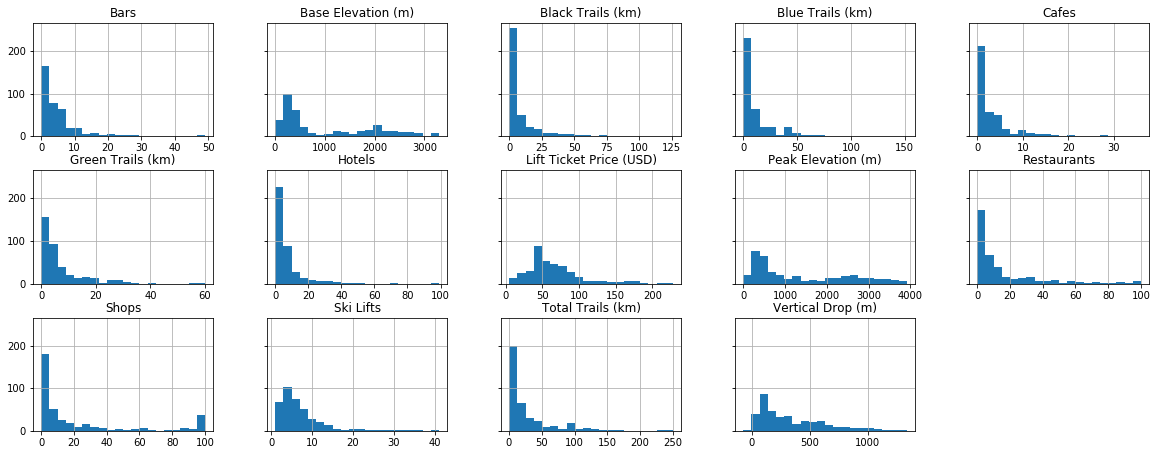

In [32]:
df_num.hist(figsize=(20, 7.5), bins=20, sharey=True, layout=(3,5))
plt.show()

#### Explore correlations.

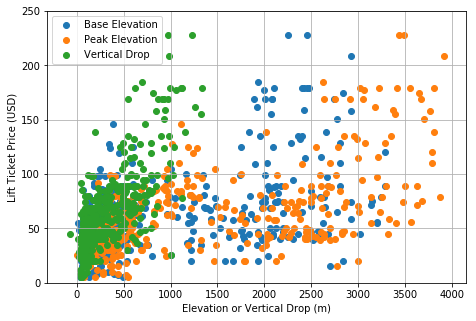

In [33]:
vars = ['Base Elevation (m)', 'Peak Elevation (m)', 'Vertical Drop (m)']
for var in vars:
    plt.scatter(df_num[var], df_num['Lift Ticket Price (USD)'], label=var.replace(' (m)', ''))
plt.xlabel('Elevation or Vertical Drop (m)')
plt.ylabel('Lift Ticket Price (USD)')
plt.gcf().set_size_inches(7.5, 5)
plt.ylim(0, 250)
plt.grid()
plt.legend(loc='best')
plt.show()

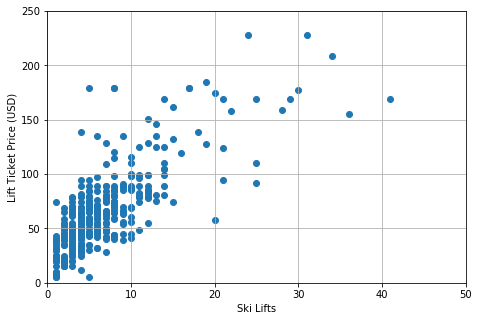

In [34]:
var = 'Ski Lifts'
plt.scatter(df_num[var], df_num['Lift Ticket Price (USD)'])
plt.xlabel(var)
plt.ylabel('Lift Ticket Price (USD)')
plt.gcf().set_size_inches(7.5,5)
plt.xlim(0, 50)
plt.ylim(0, 250)
plt.grid()
plt.show()

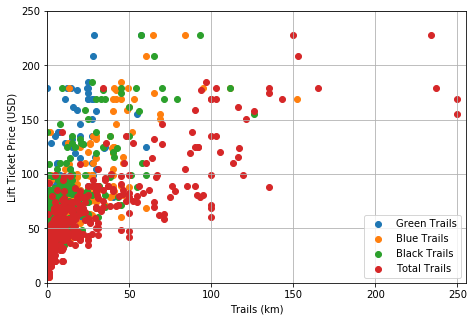

In [35]:
vars = ['Green Trails (km)', 'Blue Trails (km)', 'Black Trails (km)', 'Total Trails (km)',]
for var in vars:
    plt.scatter(df_num[var], df_num['Lift Ticket Price (USD)'], label=var.replace(' (km)', ''))
plt.xlabel('Trails (km)')
plt.ylabel('Lift Ticket Price (USD)')
plt.gcf().set_size_inches(7.5, 5)
plt.ylim(0, 250)
plt.xlim(0, 255)
plt.grid()
plt.legend(loc='best')
plt.show()

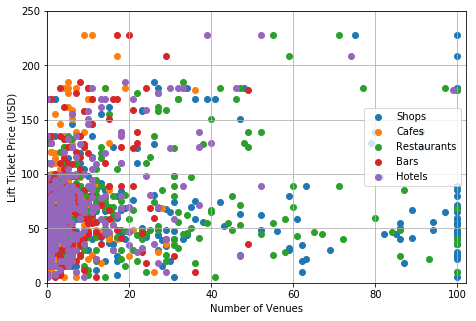

In [36]:
vars = ['Shops', 'Cafes', 'Restaurants', 'Bars', 'Hotels']
for var in vars:
    plt.scatter(df_num[var], df_num['Lift Ticket Price (USD)'], label=var.replace(' (m)', ''))
plt.xlabel('Number of Venues')
plt.ylabel('Lift Ticket Price (USD)')
plt.gcf().set_size_inches(7.5, 5)
plt.ylim(0, 250)
plt.xlim([0, 102])
plt.grid()
plt.legend(loc='best')
plt.show()

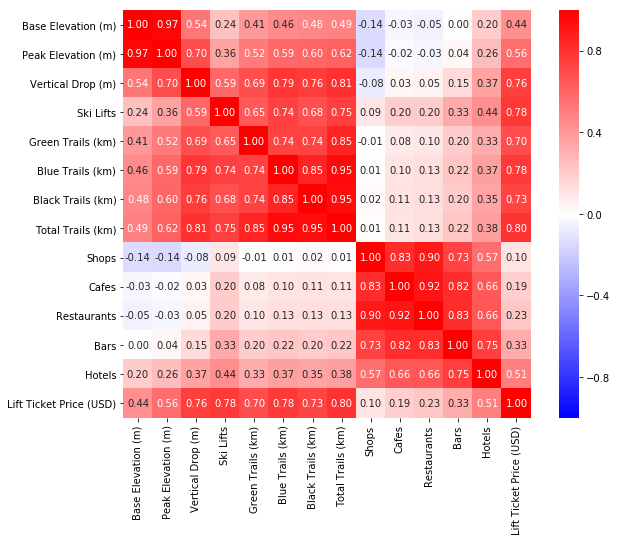

In [37]:
sns.heatmap(df_num.corr(), annot=True, fmt=".2f", square=True, cmap='bwr', vmin=-1., vmax=1.)
plt.gcf().set_size_inches(10, 7.5)
plt.show()

## Building Linear Regression Models

Let's consider several models that are different by feature selection.

In [38]:
models = {'All Stats': [
                    'Base Elevation (m)', 'Peak Elevation (m)', 'Vertical Drop (m)', 'Ski Lifts',
                    'Green Trails (km)', 'Blue Trails (km)', 'Black Trails (km)', 'Total Trails (km)'],
          'Selected Stats': [
                    'Base Elevation (m)', 'Vertical Drop (m)', 'Ski Lifts',
                    'Green Trails (km)', 'Blue Trails (km)', 'Black Trails (km)'],
          'Selected Stats & All Venues': [
                    'Base Elevation (m)', 'Vertical Drop (m)', 'Ski Lifts',
                    'Green Trails (km)', 'Blue Trails (km)', 'Black Trails (km)',
                    'Shops', 'Cafes', 'Restaurants', 'Bars', 'Hotels'],
          'Selected Stats & Venues': [
                    'Base Elevation (m)', 'Vertical Drop (m)', 'Ski Lifts',
                    'Green Trails (km)', 'Blue Trails (km)', 'Black Trails (km)',
                    'Restaurants', 'Hotels']
         }

In [39]:
def evaluate_regression_model(df, model, n_splits=4, n_repeats=25):
    r2 = np.zeros(n_repeats*n_splits)
    rms = np.zeros_like(r2)
    err = np.zeros_like(r2)
    coeff = np.zeros((1,len(model)))

    # n-fold split of the dataset repeated n_repeats times.
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=0)
    X = np.asanyarray(df[model])
    y = np.asanyarray(df[['Lift Ticket Price (USD)']])

    n = 0
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        regr = linear_model.LinearRegression()
        regr.fit(X_train, y_train)
        y_hat = regr.predict(X_test)

        r2[n] = regr.score(X_test, y_test)
        rms[n] = np.mean((y_hat - y_test)**2.)
        err[n] = np.std(y_hat - y_test)
        coeff += regr.coef_
        n += 1
        
    coeff /= n

    columns = [column.replace(') (USD)', ')').replace('(m)', '(USD/m)').replace('(km)', '(USD/km)')
               for column in ['%s (USD)' % column for column in model]]
    df_coeff = pd.DataFrame([list(coeff[0,:])], columns=columns)

    return (r2, rms, err, df_coeff)

In [40]:
models_r2 = {}
models_rms = {}
models_err = {}
for model_name in models:
    r2, rms, err, _ = evaluate_regression_model(df_num, models[model_name])
    models_r2[model_name] = r2
    models_rms[model_name] = rms
    models_err[model_name] = err

df_r2 = pd.DataFrame(models_r2)
df_rms = pd.DataFrame(models_rms)
df_err = pd.DataFrame(models_err)

## Model Evaluation

In [41]:
df_r2.describe()

,All Stats,Selected Stats,Selected Stats & All Venues,Selected Stats & Venues
count,100.000000,100.000000,100.000000,100.000000
mean,0.718174,0.713009,0.730088,0.730453
std,0.065033,0.067079,0.058489,0.057422
min,0.564915,0.562551,0.565025,0.575819
25%,0.668373,0.666345,0.684325,0.687001
50%,0.726326,0.714626,0.728977,0.730831
75%,0.774180,0.763966,0.772183,0.775014
max,0.836982,0.839847,0.862810,0.859016


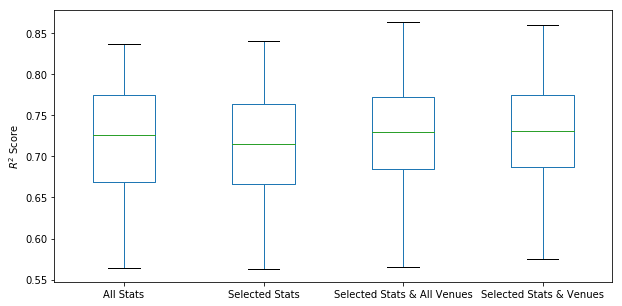

In [42]:
df_r2.plot(kind='box', figsize=(10, 5))
plt.ylabel('$R^2$ Score')
plt.show()

In [43]:
df_rms.describe()

,All Stats,Selected Stats,Selected Stats & All Venues,Selected Stats & Venues
count,100.000000,100.000000,100.000000,100.000000
mean,398.215914,405.459938,380.468365,380.225791
std,97.959536,100.399230,82.595056,82.497092
min,244.619956,241.108242,218.637211,210.405659
25%,325.678653,326.155050,321.674085,325.978766
50%,379.596698,386.969005,380.218932,377.358131
75%,454.455448,455.244504,420.578899,423.168955
max,650.088115,651.545480,566.240163,579.222922


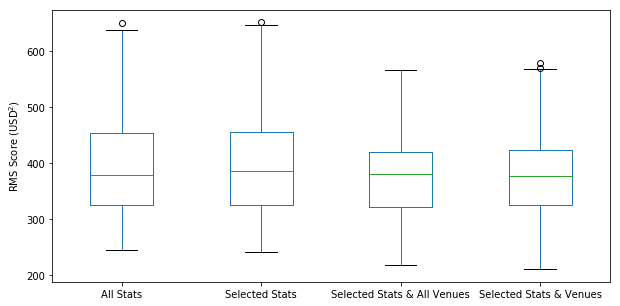

In [44]:
df_rms.plot(kind='box', figsize=(10, 5))
plt.ylabel('RMS Score (USD$^2$)')
plt.show()

In [45]:
df_err.describe()

,All Stats,Selected Stats,Selected Stats & All Venues,Selected Stats & Venues
count,100.000000,100.000000,100.000000,100.000000
mean,19.690088,19.865559,19.266056,19.259134
std,2.375642,2.417901,2.090243,2.080008
min,15.491357,15.410547,14.740506,14.453063
25%,17.987380,18.051559,17.912485,17.968487
50%,19.466599,19.616336,19.323769,19.227726
75%,21.069835,21.196707,20.354291,20.374898
max,25.409411,25.524308,23.786134,24.064206


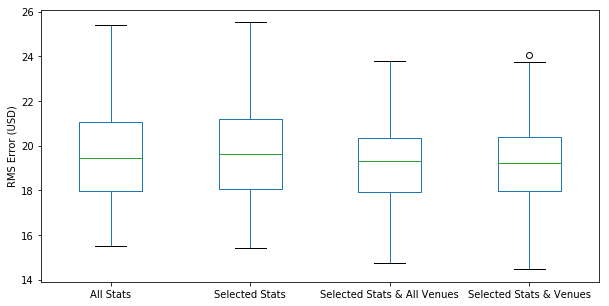

In [46]:
df_err.plot(kind='box', figsize=(10, 5))
plt.ylabel('RMS Error (USD)')
plt.show()

## Best Model Performance

### Feature coefficients.

In [47]:
r2, rms, err, df_coeff = evaluate_regression_model(df_num, models['Selected Stats & Venues'])
print('R^2 score:  %.4f+/-%.4f.' % (np.mean(r2), np.std(r2)))
print('Residual sum of squares: %.2f+/-%.2f.'  % (np.mean(rms), np.std(rms)))
print('Residual error: %.2f+/-%.2f.'  % (np.mean(err), np.std(err)))
df_coeff.head()

R^2 score:  0.7305+/-0.0571.
Residual sum of squares: 380.23+/-82.08.
Residual error: 19.26+/-2.07.


,Base Elevation (USD/m),Vertical Drop (USD/m),Ski Lifts (USD),Green Trails (USD/km),Blue Trails (USD/km),Black Trails (USD/km),Restaurants (USD),Hotels (USD)
0,0.002934,0.03758,2.530891,0.408473,0.238485,0.035625,0.059595,0.439571


### Visual evalueation of the best model performance.

In [48]:
def plot_distribution(red, blue, red_name, blue_name, title):
    plt.figure(figsize=(7.5, 5))

    ax1 = sns.distplot(red, hist=False, color="tab:red", label=red_name)
    ax2 = sns.distplot(blue, hist=False, color="tab:blue", label=blue_name, ax=ax1)

    plt.title(title)
    plt.xlabel('Lift Ticket Price (USD)')
    plt.ylabel('Frequency')
    plt.xlim(0, 250)
    plt.ylim(0, .0225)

    plt.show()

In [49]:
model = 'Selected Stats & Venues'
msk = np.random.rand(len(df_num)) < 0.75
train = df_num[msk]
test = df_num[~msk]

regr = linear_model.LinearRegression()
x_train = np.asanyarray(train[models[model]])
y_train = np.asanyarray(train[['Lift Ticket Price (USD)']])
regr.fit(x_train, y_train)
y_hat_train = regr.predict(train[models[model]])
print('Coefficients: %s' % str(regr.coef_))

y_hat_test = regr.predict(test[models[model]])
x_test = np.asanyarray(test[models[model]])
y_test = np.asanyarray(test[['Lift Ticket Price (USD)']])
print("Residual sum of squares: %.2f."  % np.mean((y_hat_test - y_test)**2.))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.4f.' % regr.score(x_test, y_test))
print('R2-value: %.4f.' % r2_score(y_test, y_hat_test))
print('R-value: %.4f' % (1. - np.mean((y_test - y_hat_test)**2.) / np.mean((y_test - np.mean(y_test))**2.)))

Coefficients: [[  1.79577637e-03   3.76372713e-02   2.68880869e+00   4.70745858e-01
   -2.98480466e-02   3.45757321e-01   3.00418002e-02   4.50996419e-01]]
Residual sum of squares: 352.59.
Variance score: 0.7716.
R2-value: 0.7716.
R-value: 0.7716


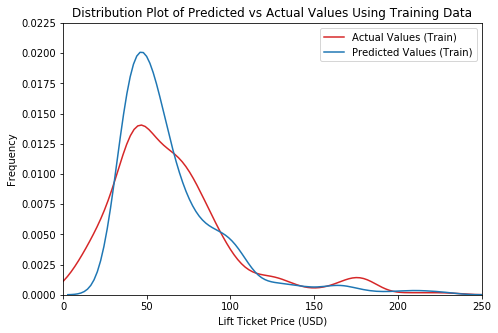

In [50]:
plot_distribution(y_train, y_hat_train, 'Actual Values (Train)', 'Predicted Values (Train)',
                  'Distribution Plot of Predicted vs Actual Values Using Training Data')

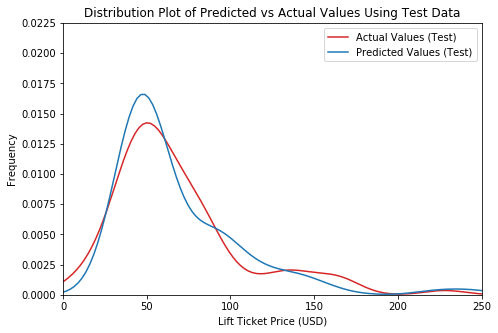

In [51]:
plot_distribution(y_test, y_hat_test, 'Actual Values (Test)', 'Predicted Values (Test)',
                  'Distribution Plot of Predicted vs Actual Values Using Test Data')